In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df_full_obs = pd.read_csv('.obs.tsv.tmp', sep='\t')
df_full_sug = pd.read_csv('.sug.tsv.tmp', sep='\t')

In [3]:
print(df_full_obs.shape)
print(df_full_sug.shape)

(70, 19)
(70, 23)


In [4]:
min_threshold = 25

obs_cols_to_keep = [
    x[0]
    for x in df_full_obs.astype('bool').sum().iteritems()
    if x[1] >= min_threshold
]

sug_cols_to_keep = [
    x[0]
    for x in df_full_sug.astype('bool').sum().iteritems()
    if x[1] >= min_threshold
]

df_smaller_obs = df_full_obs[obs_cols_to_keep]
df_smaller_sug = df_full_sug[sug_cols_to_keep]

In [5]:
print(df_smaller_obs.shape)
print(df_smaller_sug.shape)

(70, 10)
(70, 11)


In [6]:
sys.path.append('util/')
from util import *

In [7]:
max_categories = 4

valid_obs_cols_to_try = filter_for_length(get_powerset(df_smaller_obs.columns), length=3)
valid_sug_cols_to_try = filter_for_length(get_powerset(df_smaller_sug.columns), length=3)

valid_obs_cols_to_try = [x for x in valid_obs_cols_to_try if len(x) <= max_categories]
valid_sug_cols_to_try = [x for x in valid_sug_cols_to_try if len(x) <= max_categories]

In [8]:
print(len(valid_obs_cols_to_try))
print(len(valid_sug_cols_to_try))

330
495


In [9]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
folds = 3

In [10]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=Warning)

In [112]:
# this is a bad idea
to_try = 1
tried = 0

results = []

# try:
#     for obs_subset in valid_obs_cols_to_try[::-1]:
#         for sug_subset in valid_sug_cols_to_try[::-1]:
#             if tried >= to_try:
#                 raise StopIteration
# #             if tried % 10 == 0:
#             print(tried, end='  ')

#             selected_obs = df_smaller_obs[obs_subset]
# #             selected_sug = df_smaller_sug[sug_subset]
            
#             all_scores = []
#             for sug_label in sug_subset:
#                 single_label_cv_score = cross_val_score(
#                     rf, selected_obs, df_smaller_sug[[sug_label]], cv=folds
#                 )
#                 all_scores.append(single_label_cv_score.mean())
            
#             macro_averaged_subset_score = sum(all_scores) / len(all_scores)
            
# #             print(macro_averaged_subset_score)
# #             scores = cross_val_score(rf, selected_obs, selected_sug, cv=folds)
        
#             results.append(tuple([
#                 macro_averaged_subset_score,
#                 obs_subset,
#                 sug_subset
#             ]))
            
#             tried += 1
            
# except StopIteration:
#     pass

# sorted_results = sorted(results, key=lambda x: x[0])

In [12]:
len(results)

1

In [13]:
results

[(0.4939692915779872,
  ['PUNCTUATION', 'RATE', 'SELF_CORRECTION', 'SIGHT_WORDS'],
  ['PUNCTUATION', 'SELF_MONITOR', 'SIGHT_WORD', 'WORD_ENDINGS'])]

different approach, heatmap

heatmap among observations

In [16]:
import seaborn as sns
import matplotlib.pylab as plt

In [17]:
test_a = pd.Series([1, 0, 1])
test_

In [24]:
df_obs_ternary = df_full_obs.copy()
m, n = df_obs_ternary.shape
for ri in range(m):
    for ci in range(n):
        if df_obs_ternary.iat[ri, ci] > 0:
            df_obs_ternary.iat[ri, ci] = 1
        if df_obs_ternary.iat[ri, ci] < 0:
            df_obs_ternary.iat[ri, ci] = -1

In [31]:
def match_sim(l1, l2):
    assert len(l1) == len(l2)
    return len([x for idx, x in enumerate(l1) if l2[idx] == x]) / len(l1)

pair_sims = set()

for column in df_obs_ternary:
    for other_column in df_obs_ternary:
        sim = match_sim(list(df_obs_ternary[column]), list(df_obs_ternary[other_column]))
        pair_sims.add(tuple([sim, column, other_column]))
        

In [39]:
len(pair_sims) ** .5 == n

True

In [43]:
from collections import defaultdict
sims_dict = defaultdict(dict)

for pair_sim in pair_sims:
    sim, cat1, cat2 = pair_sim
    sims_dict[cat1][cat2] = sim

In [62]:
obs_corr_mat = []
for idx in range(len(df_obs_ternary.columns)):
    orig = list(df_obs_ternary.columns)[idx]
    to_append = [sims_dict[orig][col_title] for col_title in df_obs_ternary.columns]
    
    obs_corr_mat.append(to_append)

In [70]:
obs_corr_df = pd.DataFrame(obs_corr_mat)
obs_corr_df.columns = df_obs_ternary.columns
obs_corr_df_row_names = {
    idx: name
    for idx, name in enumerate(list(df_obs_ternary))
}
obs_corr_df.rename(index=obs_corr_df_row_names, inplace=True)

In [105]:
def heat(df, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    sns.heatmap(df, cmap='Blues')
    plt.show()

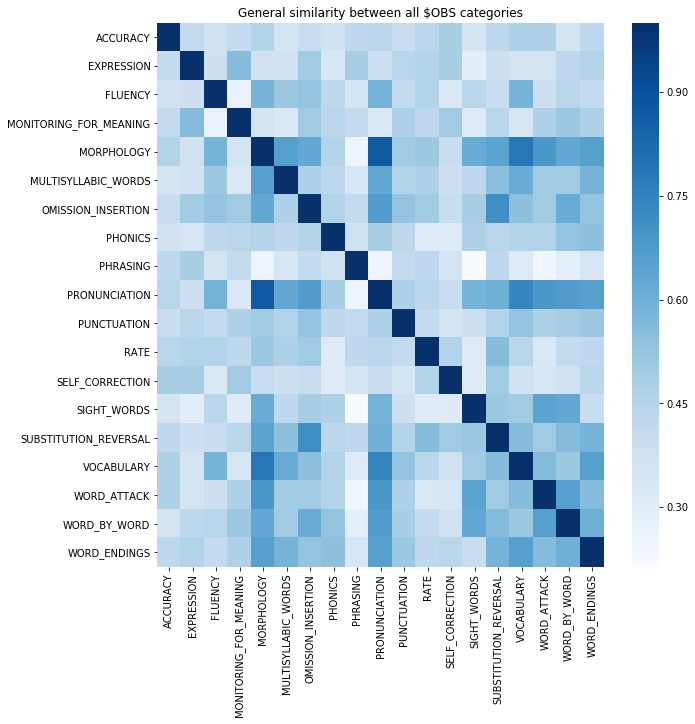

In [106]:
heat(obs_corr_df, title='General similarity between all $OBS categories')

removing sparse columns

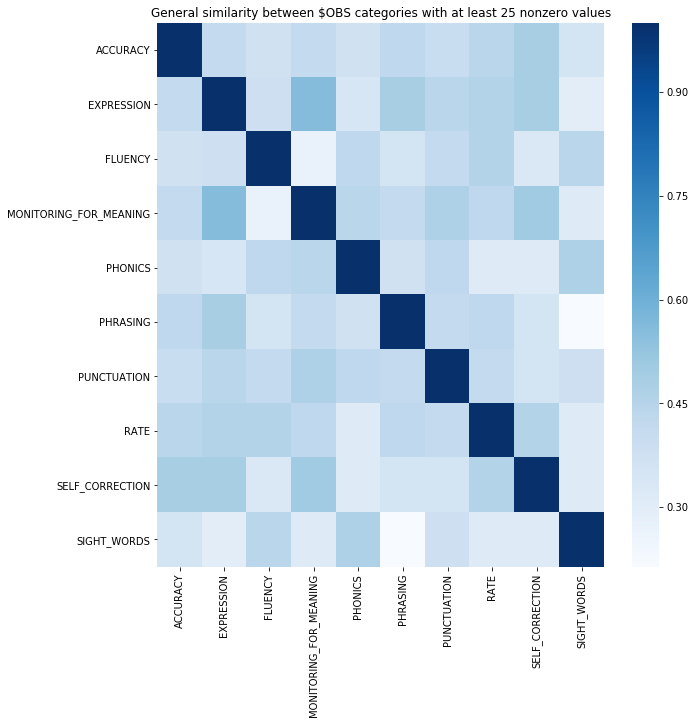

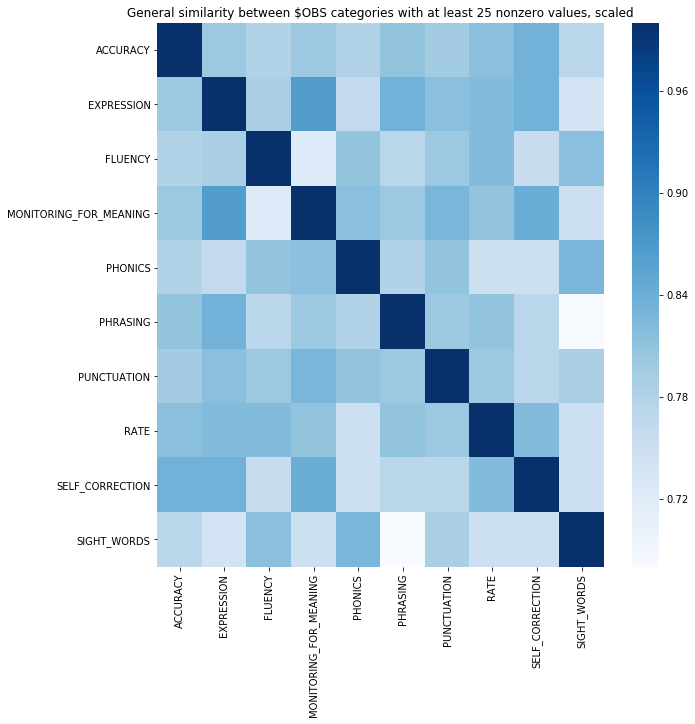

In [120]:
minimum = 25
to_drop = [
    x
    for x, y in dict(df_obs_ternary.astype('bool').sum()).items()
    if y < minimum
]
smaller_obs_corr_df = obs_corr_df.drop(to_drop).drop(to_drop, axis=1)
heat(
    smaller_obs_corr_df,
    title='General similarity between $OBS categories with at least {} nonzero values'.format(minimum)
)
scaled_smaller_obs_corr_df = smaller_obs_corr_df.copy()
for col in scaled_smaller_obs_corr_df:
    scaled_smaller_obs_corr_df[col] = (scaled_smaller_obs_corr_df[col]) ** .25
heat(
    scaled_smaller_obs_corr_df,
    title='General similarity between $OBS categories with at least {} nonzero values, scaled'.format(minimum)
)